 TODOs (intentionally not implemented):
- `build_training_data`
- `class PINN`
- `model_loss`
- `train`


In [22]:
%pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [23]:
import math
from typing import Tuple

import numpy as np
import torch
import torch.nn as nn
from scipy.integrate import quad


def build_training_data(
    num_bc: Tuple[int, int] = (25, 25),
    num_ic: int = 50,
    num_f: int = 10_000,
    seed: int = 0,
):
    """
    TODO : Implement the training-data construction.

    Target behavior (same as original script):
    - Create BC samples for x=-1 and x=1, t in [0,1], u=0
    - Create IC samples for t=0, x in [-1,1], u=-sin(pi x)
    - Create interior collocation points (x,t) in (-1,1)x(0,1)
    - Return: xf, tf, x0, t0, u0
    """

    # u(-1, t) = 0 and u(1,t) = 0
    t0_bc1 = torch.linspace(0.0, 1.0, num_bc[0]).view(-1,1)
    t0_bc2 = torch.linspace(0.0, 1.0, num_bc[1]).view(-1,1)
    x0_bc1 = -torch.ones(num_bc[0],1)
    x0_bc2 = torch.ones(num_bc[1],1)
    u0_bc1 = torch.zeros(num_bc[0], 1)
    u0_bc2 = torch.zeros(num_bc[1], 1)

    # Initial condition: u(x,0) = -sin(pi x) 
    x0_ic = torch.linspace(-1., 1., num_ic).view(-1,1)
    t0_ic = torch.zeros(num_ic, 1)
    u0_ic = - torch.sin(torch.pi * x0_ic)

    x_bc = torch.cat([x0_bc1,x0_bc2], dim=0)
    t_bc = torch.cat([t0_bc1,t0_bc2], dim=0)
    u_bc = torch.cat([u0_bc1,u0_bc2], dim=0) 
    # put everything as a matrix together 

    # Interior collocation points in (x,t) in (-1, 1) x (0,1)

    points = torch.rand(num_f, 2) # uniformly distributed from [0,1]
    xf = 2.0 * points[:, 0:1] - 1.0
    tf = points[:,1:2] 

    return xf, tf, x0_ic, t0_ic, u0_ic,x_bc, t_bc, u_bc 

    

     
     




    raise NotImplementedError("TODO: implement build_training_data")


class PINN(nn.Module):
    def __init__(self, in_dim: int = 2, hidden_dim: int = 16, num_hidden: int = 8, out_dim: int = 1):
        super().__init__()
        layers = [nn.Linear(in_dim, hidden_dim), nn.Tanh()]

        for _ in range(num_hidden - 1):
            layers += [nn.Linear(hidden_dim, hidden_dim), nn.Tanh()]
        layers += [nn.Linear(hidden_dim, out_dim)]
        self.pinn = nn.Sequential(*layers) 
    
    def forward(self, x):
        return self.pinn(x) 

        
        


def grad(outputs, inputs):  # compute derivative of outputs w.r.t. inputs 
    return torch.autograd.grad( 
        outputs,
        inputs,
        grad_outputs=torch.ones_like(outputs), 
        create_graph= True,  
        retain_graph=True,
    )[0]

def pde(u,x,t, nu ): 
    u_x = grad(u,x)
    u_t = grad(u,t)
    u_xx = grad(u_x, x)
    f = u_t + u*u_x - nu*u_xx
    return f

def model_loss(
        net: nn.Module, 
        xf: torch.Tensor, # input to PDE
        tf: torch.Tensor, 
        x0: torch.Tensor, # IC
        t0: torch.Tensor, 
        u0: torch.Tensor, 
        x_bc: torch.Tensor, # BC  
        t_bc: torch.Tensor, 
        u_bc: torch.Tensor,  
        mse ):
    """
    TODO : Implement PINN loss.

    """
    nu = .01 / torch.pi 

    x = xf.requires_grad_(True)
    t = tf.requires_grad_(True)

    u = net(torch.cat([x,t], dim = 1))

    f = pde(u, x, t, nu) 
    mse_f = mse(f, torch.zeros_like(f))

    u0_pred = net(torch.cat([x0, t0], dim=1))
    mse_0 = mse(u0, u0_pred)

    u_bc_pred = net(torch.cat([x_bc, t_bc], dim=1))
    mse_bc = mse(u_bc, u_bc_pred) 
    loss = mse_f + mse_0 + mse_bc

    return loss, mse_f , mse_0 , mse_bc




def solve_burgers(x: np.ndarray, t: float, nu: float) -> np.ndarray:
    if t <= 0:
        raise ValueError("t must be > 0 for this reference solution.")

    def f(y):
        return np.exp(-np.cos(np.pi * y) / (2 * np.pi * nu))

    def g(y):
        return np.exp(-(y**2) / (4 * nu * t))

    u = np.zeros_like(x, dtype=np.float64)
    for i, xi in enumerate(x):
        if abs(xi) != 1.0:
            num_fun = lambda eta: np.sin(np.pi * (xi - eta)) * f(xi - eta) * g(eta)
            den_fun = lambda eta: f(xi - eta) * g(eta)
            num = -quad(num_fun, -np.inf, np.inf, limit=200)[0]
            den = quad(den_fun, -np.inf, np.inf, limit=200)[0]
            u[i] = num / den
    return u


def train():
    """
    TODO: Implement training loop.
    """
    torch.set_default_dtype(torch.float64)
    device = torch.device("cpu")

    xf, tf,  x_ic, t_ic, u_ic, x_bc, t_bc, u_bc = build_training_data()
    xf, tf, x_ic, t_ic, u_ic, x_bc, t_bc, u_bc = [
        z.to(device) for z in (xf, tf, x_ic, t_ic, u_ic, x_bc, t_bc, u_bc)
    ]

    net = PINN().to(device)

    max_iterations = 50

    mse = nn.MSELoss()

    optimizer = torch.optim.LBFGS(
        net.parameters(),
        lr = 0.1, 
        history_size=50, 
    )

    for iteration in range(1, max_iterations +1 ):
        def closure():
            optimizer.zero_grad()
            loss,_ ,_ ,_ = model_loss(net, xf, tf, x_ic, t_ic, u_ic, x_bc, t_bc, u_bc,mse)
            loss.backward()
            return loss
        loss = optimizer.step(closure)

        # from here classically 
        optimizer.zero_grad()
        loss_value, mse_f, mse_ic, mse_bc = model_loss(net, xf, tf, x_ic, t_ic, u_ic, x_bc, t_bc, u_bc,mse)
        loss_value.backward()

        if iteration % 50 == 0 or iteration == 1:
            print(
                f"iter={iteration:4d}  loss={loss_value.item():.6e}  "
                f"mse_f={mse_f.item():.6e}  mse_ic={mse_ic.item():.6e}  mse_bc={mse_bc.item():.6e}  "
            )
    
    return net 


def evaluate(net: nn.Module):
    import matplotlib.pyplot as plt

    net.eval()
    nu = 0.01 / math.pi

    t_test = [0.25, 0.5, 0.75, 1.0]
    x_test = np.linspace(-1.0, 1.0, 1001)

    u_pred = []
    u_true = []

    with torch.no_grad():
        x_torch = torch.from_numpy(x_test).view(-1, 1)
        for t in t_test:
            t_torch = torch.full_like(x_torch, t)
            xt = torch.cat([x_torch, t_torch], dim=1)
            u_p = net(xt).cpu().numpy().reshape(-1)
            u_t = solve_burgers(x_test, t, nu)
            u_pred.append(u_p)
            u_true.append(u_t)

    u_pred = np.stack(u_pred, axis=0)
    u_true = np.stack(u_true, axis=0)
    err = np.linalg.norm(u_pred - u_true) / np.linalg.norm(u_true)
    print(f"Relative L2 error: {err:.4f}")

    fig, axes = plt.subplots(2, 2, figsize=(10, 7), constrained_layout=True)
    axes = axes.ravel()
    for i, t in enumerate(t_test):
        axes[i].plot(x_test, u_pred[i], "-", lw=2, label="Prediction")
        axes[i].plot(x_test, u_true[i], "--", lw=2, label="Target")
        axes[i].set_ylim(-1.1, 1.1)
        axes[i].set_xlabel("x")
        axes[i].set_ylabel(f"u(x, {t})")
    axes[0].legend()
    plt.show()


iter=   1  loss=4.906809e-01  mse_f=5.954264e-06  mse_ic=4.896933e-01  mse_bc=9.816135e-04  
iter=  50  loss=1.791053e-03  mse_f=1.313112e-03  mse_ic=4.385024e-04  mse_bc=3.943885e-05  
Relative L2 error: 0.0332


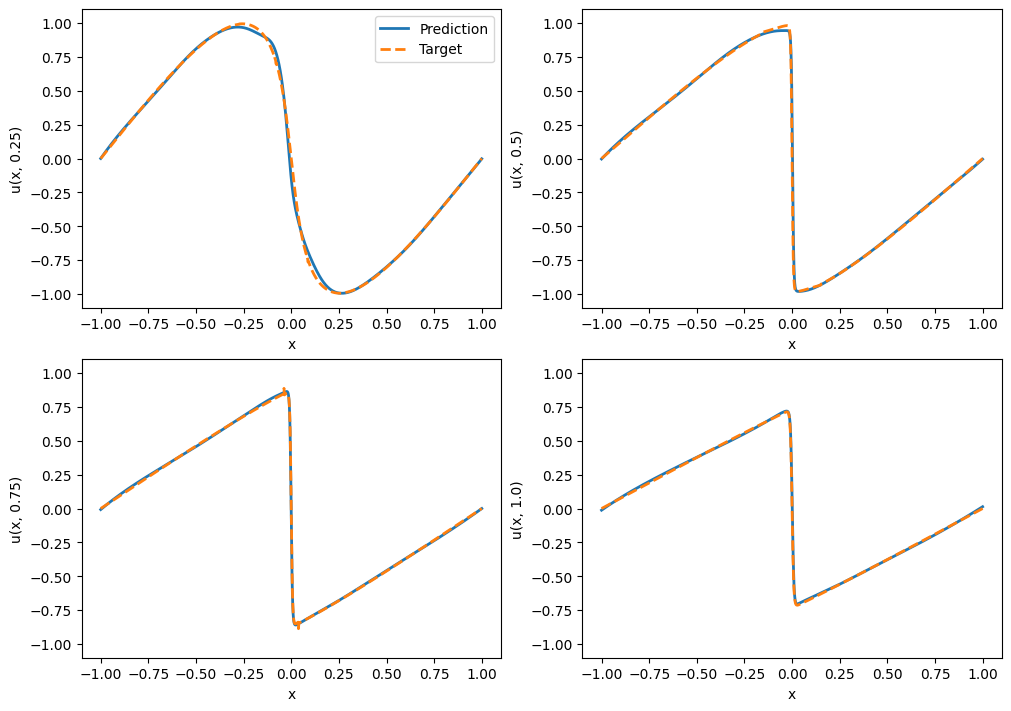

In [24]:
# Run after implementing all TODOs:
model = train()
evaluate(model)
